## Setup Codes

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section. Run the following cell to mount your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below.

In [3]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 'Test' folder and put all the files under 'example' folder, then 'Test/example'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Test/example'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'GIT/tutorials/utils/Convolutional_Neural_Network'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

['utils', 'resnet.py']


### Setup Code

Run some setup code for this notebook: Import some useful packages

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# custom utils
import utils.utils as utils
import utils.data as data
import utils.modules as modules
import utils.layers as layers

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

### Load the CIFAR-10 dataset
 The utility function eecs598.data.preprocess_cifar10() returns the entire CIFAR-10 dataset as a set of six Torch tensors while also preprocessing the RGB images:

100%|██████████| 170498071/170498071 [00:03<00:00, 48322756.46it/s]


Extracting ./cifar-10-python.tar.gz to .


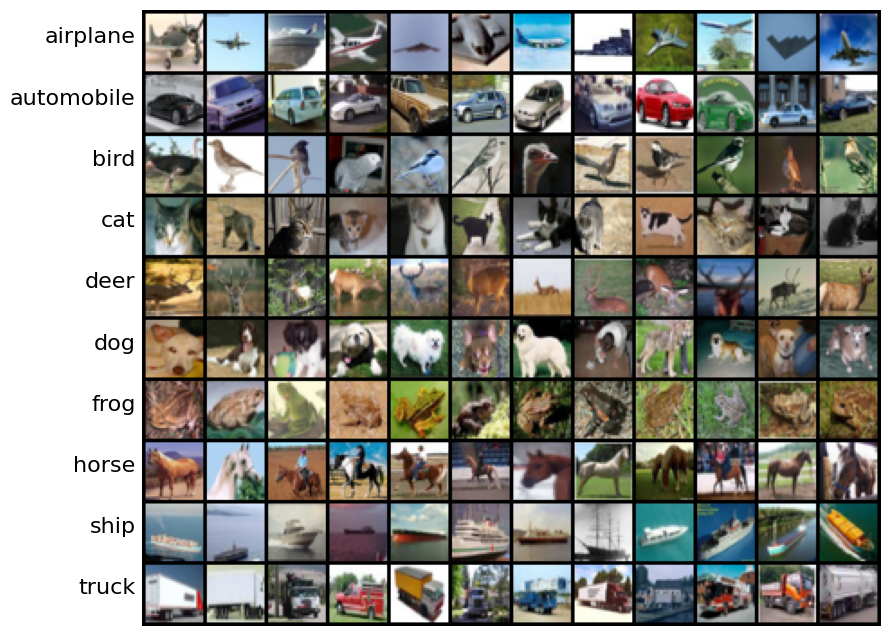

In [5]:
dset_train, dset_val, dset_test = data.load_data(name='cifar10',
                                                 sample_ratio=None,
                                                 show_examples=True,
                                                 flatten=False,
                                                 val_ratio=0.2)

data_loaders = {}
data_loaders['train'] = torch.utils.data.DataLoader(dset_train, batch_size=64, shuffle=True)
data_loaders['val'] = torch.utils.data.DataLoader(dset_val, batch_size=64, shuffle=True)
data_loaders['test'] = torch.utils.data.DataLoader(dset_test, batch_size=64, shuffle=False)

## Recurrent Neural Networks

In [136]:
class RNNCell(nn.Module):
  def __init__(self, input_dim, hidden_dim, device='cpu'):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.Wx = nn.Parameter(modules.xavier_init(input_dim, hidden_dim)).to(device)
    self.Wh = nn.Parameter(modules.xavier_init(hidden_dim, hidden_dim)).to(device)
    self.b = nn.Parameter(torch.zeros(hidden_dim)).to(device)

  def forward(self, x, h0=None):

    assert h0 is not None

    xw = torch.matmul(x, self.Wx)
    hw = torch.matmul(h0, self.Wh)
    next_h = torch.tanh(xw + hw + self.b)
    return next_h

In [137]:
class LSTMCell(nn.Module):
  def __init__(self, input_dim, hidden_dim, device='cpu'):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.Wx = nn.Parameter(modules.xavier_init(input_dim, hidden_dim * 4)).to(device)
    self.Wh = nn.Parameter(modules.xavier_init(hidden_dim, hidden_dim * 4)).to(device)
    self.b = nn.Parameter(torch.zeros(hidden_dim * 4)).to(device)

  def forward(self, x, h0=None, prev_c=None):

    assert h0 is not None
    assert prev_c is not None

    xw = torch.matmul(x, self.Wx)
    hw = torch.matmul(h0, self.Wh)
    a = xw + hw + self.b

    ai, af, ao, ag = a.chunk(4, 1)

    gi = torch.sigmoid(ai)
    gf = torch.sigmoid(af)
    go = torch.sigmoid(ao)
    gg = torch.tanh(ag)

    next_c = gf * prev_c + gi * gg
    next_h = go * torch.tanh(next_c)

    return next_h, next_c

In [138]:
class ReccurentNeuralNetworks(nn.Module):
  def __init__(self, input_dim, hidden_dim,
               num_layers=1, bidirectional=1,
               cell_type='rnn', cell=RNNCell,
               device='cpu'):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.cell_type = cell_type

    self.forward_cells = nn.ModuleList([cell(input_dim, hidden_dim, device)])
    self.backward_cells = nn.ModuleList([cell(input_dim, hidden_dim, device)])

    for _ in range(1, num_layers):
      self.forward_cells.append(cell(hidden_dim, hidden_dim, device))
      self.backward_cells.append(cell(hidden_dim, hidden_dim, device))


  def forward(self, x, h0=None):

    if h0 is None:
      h0 = torch.zeros(x.size(0), self.hidden_dim).to(x.device)

    out_forward = []
    out_backward = []

    prev_h_forward = [h0] * self.num_layers
    prev_h_backward = [h0] * self.num_layers

    if self.cell_type == 'lstm':
      prev_c_forward = [h0] * self.num_layers
      prev_c_backward = [h0] * self.num_layers


    for t in range(x.size(1)):
      input_forward = x[:, t]
      input_backward = x[:, -t-1]

      for i in range(self.num_layers):

        if self.cell_type == 'lstm':
          prev_h_forward[i], prev_c_forward[i]  = self.forward_cells[i](input_forward, prev_h_forward[i], prev_c_forward[i])
          prev_h_backward[i], prev_c_backward[i] = self.backward_cells[i](input_backward, prev_h_backward[i], prev_c_backward[i])
        else:
          prev_h_forward[i] = self.forward_cells[i](input_forward, prev_h_forward[i])
          prev_h_backward[i] = self.backward_cells[i](input_backward, prev_h_backward[i])

        input_forward = prev_h_forward[i]
        input_backward = prev_h_backward[i]

      out_forward.append(input_forward)
      out_backward.append(input_backward)


    out_forward = torch.stack(out_forward, dim=1)
    out_backward = torch.stack(out_backward, dim=1)

    output = torch.cat([out_forward, out_backward], dim=-1)
    hn = torch.cat([input_forward.unsqueeze(0), input_backward.unsqueeze(0)], dim=0)

    return output, hn


In [139]:
class RNN(ReccurentNeuralNetworks):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional=False, device='cpu'):
        super().__init__(input_dim, hidden_dim, num_layers, bidirectional, 'rnn', RNNCell, device)

class LSTM(ReccurentNeuralNetworks):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional=False, device='cpu'):
        super().__init__(input_dim, hidden_dim, num_layers, bidirectional, 'lstm', LSTMCell, device)

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ManyToOne(nn.Module):
    def __init__(self, input_dims=(3, 32, 32),
                 hidden_dim=300,
                 out_dim=10,
                 patch_size=8,
                 mode='rnn',
                 bidirectional=False,
                 num_layers=1,
                 device='cpu'):
        super().__init__()

        C, H, W = input_dims

        assert H % patch_size == 0, "Height is not divisible by patch size"
        assert W % patch_size == 0, "Width is not divisible by patch size"

        in_dim = ((W - patch_size) // patch_size + 1) * ((H - patch_size) // patch_size + 1) * 3

        self.patch_size = patch_size
        self.conv = nn.Conv2d(in_channels=in_dim, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

        bidirectional = 2 if bidirectional else 1

        if mode == 'rnn':
            self.rnn = RNN(self.patch_size * self.patch_size, hidden_dim, num_layers, bidirectional, device)
        elif mode == 'lstm':
            self.rnn = LSTM(self.patch_size * self.patch_size, hidden_dim, num_layers, bidirectional, device)


        self.fc = nn.Linear(hidden_dim * bidirectional, out_dim)


    def forward(self, x):
        patches = F.unfold(x, kernel_size=self.patch_size, stride=self.patch_size)
        patches = patches.view(x.size(0), -1, self.patch_size, self.patch_size)

        out = self.conv(patches).flatten(start_dim=2)
        out = self.relu(out)


        out, _ = self.rnn(out)

        out = out[:, -1, :]
        out = self.fc(out)


        return out


## Sanity Check

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N, D, T, H = 5, 192, 50, 100
x = torch.randn(N, 3, 32, 32).to(device)
y = torch.randint(10, size=(N,), dtype=torch.int64).to(device)
criterion = nn.CrossEntropyLoss()

In [42]:
def sanity_check(model, msg='untiltled'):
  model = model.to(device)
  out= model(x)
  loss = criterion(out, y)

  print(f'{msg} : {loss.item()}')

  loss.backward()

In [43]:
sanity_check(ManyToOne(mode='lstm', num_layers=2, bidirectional=True, device=device), msg='LSTM')
sanity_check(ManyToOne(mode='rnn', num_layers=2, bidirectional=True, device=device), msg='RNN')

LSTM : 2.314060688018799
RNN : 2.4783782958984375


## Overfit small data

In [44]:
dset_train, dset_val, dset_test = data.load_data(name='cifar10',
                                                 sample_ratio=0.005,
                                                 show_examples=False,
                                                 flatten=False,
                                                 val_ratio=0.2)

print(f"number of train samples : {len(dset_train)}")
print(f"number of val samples : {len(dset_val)}")
print(f"number of test samples : {len(dset_test)}")

sample_loaders = {}
sample_loaders['train'] =  torch.utils.data.DataLoader(dset_train, batch_size=64, shuffle=True)
sample_loaders['val'] = torch.utils.data.DataLoader(dset_val, batch_size=64, shuffle=True)
sample_loaders['test'] = torch.utils.data.DataLoader(dset_test, batch_size=64, shuffle=False)

model = ManyToOne(mode='rnn', num_layers=2, bidirectional=True, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

history = utils.runner(model, criterion, optimizer, sample_loaders, num_epochs=30, msg=True)

number of train samples : 200
number of val samples : 50
number of test samples : 50
Train using cuda
Epoch [1/30]          train Loss: 2.2597          train ACC: 13.00%          val Loss: 2.2470          val ACC: 18.00%
Epoch [2/30]          train Loss: 2.1021          train ACC: 31.50%          val Loss: 2.2249          val ACC: 28.00%
Epoch [3/30]          train Loss: 1.9756          train ACC: 39.00%          val Loss: 2.2021          val ACC: 26.00%
Epoch [4/30]          train Loss: 1.8838          train ACC: 43.50%          val Loss: 2.1612          val ACC: 24.00%
Epoch [5/30]          train Loss: 1.7273          train ACC: 52.00%          val Loss: 2.1145          val ACC: 24.00%
Epoch [6/30]          train Loss: 1.6002          train ACC: 59.00%          val Loss: 2.0595          val ACC: 26.00%
Epoch [7/30]          train Loss: 1.5486          train ACC: 62.00%          val Loss: 2.0454          val ACC: 28.00%
Epoch [8/30]          train Loss: 1.4999          train ACC: 63.5

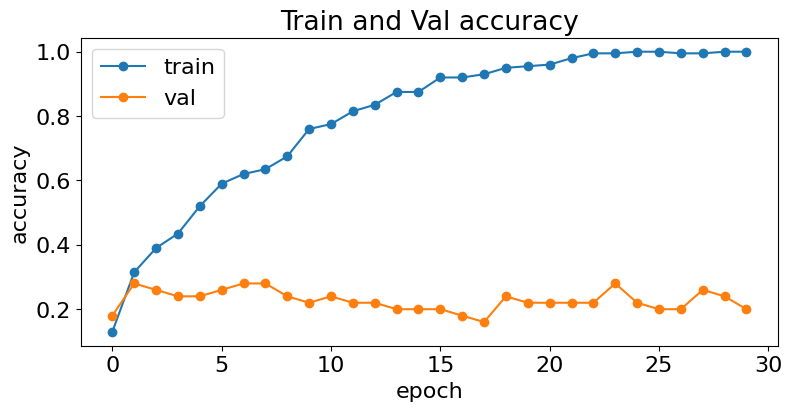

In [45]:
utils.visulaize_history(history['trainACC'], history['valACC'], title='accuracy')

In [142]:
model = ManyToOne(mode='lstm', num_layers=1, bidirectional=True, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

history = utils.runner(model, criterion, optimizer, sample_loaders, num_epochs=30, msg=True)

Train using cuda
Epoch [1/30]          train Loss: 2.3391          train ACC: 10.00%          val Loss: 2.2868          val ACC: 22.00%
Epoch [2/30]          train Loss: 2.2760          train ACC: 14.50%          val Loss: 2.2461          val ACC: 18.00%
Epoch [3/30]          train Loss: 2.2441          train ACC: 16.50%          val Loss: 2.1710          val ACC: 24.00%
Epoch [4/30]          train Loss: 2.1382          train ACC: 22.50%          val Loss: 2.1903          val ACC: 28.00%
Epoch [5/30]          train Loss: 1.9647          train ACC: 29.50%          val Loss: 2.2433          val ACC: 20.00%
Epoch [6/30]          train Loss: 1.9704          train ACC: 29.50%          val Loss: 2.2353          val ACC: 24.00%
Epoch [7/30]          train Loss: 1.8703          train ACC: 34.00%          val Loss: 2.1782          val ACC: 24.00%
Epoch [8/30]          train Loss: 1.6183          train ACC: 39.50%          val Loss: 2.1636          val ACC: 26.00%
Epoch [9/30]          train Los

## Train the Net

In [46]:
model = ManyToOne(mode='rnn', num_layers=2, bidirectional=True, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

history = utils.runner(model, criterion, optimizer, data_loaders, num_epochs=10, msg=True)

Train using cuda
Epoch [1/10]          train Loss: 1.6474          train ACC: 41.09%          val Loss: 1.5246          val ACC: 45.76%
Epoch [2/10]          train Loss: 1.4554          train ACC: 48.19%          val Loss: 1.4659          val ACC: 47.99%
Epoch [3/10]          train Loss: 1.3903          train ACC: 50.57%          val Loss: 1.4583          val ACC: 48.57%
Epoch [4/10]          train Loss: 1.3459          train ACC: 52.31%          val Loss: 1.4194          val ACC: 49.48%
Epoch [5/10]          train Loss: 1.3094          train ACC: 53.32%          val Loss: 1.3992          val ACC: 50.68%
Epoch [6/10]          train Loss: 1.2839          train ACC: 54.63%          val Loss: 1.3922          val ACC: 51.36%
Epoch [7/10]          train Loss: 1.2623          train ACC: 55.34%          val Loss: 1.3750          val ACC: 51.56%
Epoch [8/10]          train Loss: 1.2429          train ACC: 55.63%          val Loss: 1.3868          val ACC: 51.52%
Epoch [9/10]          train Los

In [143]:
model = ManyToOne(mode='lstm', num_layers=1, bidirectional=True, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

history = utils.runner(model, criterion, optimizer, data_loaders, num_epochs=10, msg=True)

Train using cuda
Epoch [1/10]          train Loss: 1.7374          train ACC: 37.84%          val Loss: 1.5994          val ACC: 43.05%
Epoch [2/10]          train Loss: 1.5416          train ACC: 44.98%          val Loss: 1.5235          val ACC: 46.10%
Epoch [3/10]          train Loss: 1.4743          train ACC: 47.46%          val Loss: 1.5127          val ACC: 46.23%
Epoch [4/10]          train Loss: 1.4323          train ACC: 48.95%          val Loss: 1.4942          val ACC: 47.17%
Epoch [5/10]          train Loss: 1.3991          train ACC: 50.19%          val Loss: 1.4726          val ACC: 48.68%
Epoch [6/10]          train Loss: 1.3670          train ACC: 51.48%          val Loss: 1.4711          val ACC: 48.14%
Epoch [7/10]          train Loss: 1.3489          train ACC: 52.10%          val Loss: 1.4787          val ACC: 48.29%
Epoch [8/10]          train Loss: 1.3305          train ACC: 52.69%          val Loss: 1.4590          val ACC: 48.91%
Epoch [9/10]          train Los